# Building Machine Learning Systems with Python - Chapter 5

# STEP0 Preparation

## 0.1 How to use this notebook
- Login to horn sever
- Find the file `/work/Bulid_machine_learning/chapter05_Wang/chapter_05.ipynb`
- Copy the `chapter_05.ipynb` to your own folder. Then cd to your folder.  
``` shell
# For example, I use the following code
cd /work/Bulid_machine_learning/chapter05_Wang/
cp chapter_05.ipynb /home/wang/bookML/
cd /home/wang/bookML/
```
- now start jupyter notebook on your own horn folder 
``` shell
#On horn server, use your own port
jupyter notebook --no-browser --port=8888
#Back to the terminal of local PC (not no server), then run:
ssh -N -f -L localhost:8888:localhost:8888 wang@horn
#Now open your web browser with http://localhost:8880/
```

## 0.2 Our purpose
- A example Question and answers from Stackoverflow

- Purpose: **Classify whether an answer is good or not**

![alt](https://i.loli.net/2020/05/21/bLzqhQoSCGvcTdy.png)

 ## 0.3 Check your Python version, we need python3

In [62]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

## 0.4 import numpy and nltk (Natural Language Toolkit).
- If nltk is not avaliable, please run `pip3 install nltk`

In [4]:
import numpy as np
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/wang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 0.5 Downloading the data
- It is already prepared on `horn:/work/Bulid_machine_learning/chapter05_Wang/data/Posts.xml`, a 74 GB xml file.
- **You don't need to do anything.**
- The content of our xml file is like: (xmlファイル属性については、Page86の表5-2の通りです）

``` xml
  <row Id="41412463" PostTypeId="1" AcceptedAnswerId="41412502" CreationDate="2017-01-01T00:02:29.813" Score="1" ViewCount="649" Body="&lt;p&gt;I have a global variable&#xA;&lt;code&gt;global.loggedInUsers = {};&lt;/code&gt;. This object is used as and dictionary is occupied with unique &lt;code&gt;key:value&lt;/code&gt; pairs.&lt;/p&gt;&#xA;&#xA;&lt;p&gt;The key is unique an the value is an account object.&lt;/p&gt;&#xA;&#xA;&lt;pre&gt;&lt;code&gt;function Account(hash, jsonData) {&#xA;  this.hash = hash;&#xA;  this.accountJson = JSON.parse(jsonData);&#xA;  this.pongUpdate = 20;&#xA;  setInterval(function() {&#xA;    // Stuff happens here blah blah&#xA;  }, 1000);&#xA;}&#xA;&#xA;Account.protoype....&#xA;&lt;/code&gt;&lt;/pre&gt;&#xA;&#xA;&lt;p&gt;At some point in my code eventually I call the delete function&lt;/p&gt;&#xA;&#xA;&lt;pre&gt;&lt;code&gt;delete(loggedInUsers.key);&#xA;&lt;/code&gt;&lt;/pre&gt;&#xA;&#xA;&lt;p&gt;Because the &lt;code&gt;Account&lt;/code&gt; class encases the &lt;code&gt;setInterval&lt;/code&gt; call, if the &lt;code&gt;Account&lt;/code&gt; object is deleted will the setInterval stop or do I have to store setInterval in a variable handle it in a destructor?&lt;/p&gt;&#xA;" OwnerUserId="2553939" LastEditorUserId="2553939" LastEditDate="2017-01-01T00:18:43.323" LastActivityDate="2017-01-01T00:51:06.773" Title="Is Javascript's setInterval killed when the parent object is destroyed?" Tags="&lt;javascript&gt;&lt;node.js&gt;" AnswerCount="1" CommentCount="4" />
  <row Id="41412464" PostTypeId="2" ParentId="41410880" CreationDate="2017-01-01T00:02:38.957" Score="0" Body="&lt;p&gt;A chrome extension can only run javascript, but you could write a sinatra app and have the javascript access it.&lt;/p&gt;&#xA;" OwnerUserId="4948732" LastActivityDate="2017-01-01T00:02:38.957" CommentCount="1" />
```

- This xml file conatin all questions and its answers. One Question can have 0, 1, or more than 1 answers.

## 0.6 Outline of this chapter
- Fetching and preprocessiong the raw data
- Creating a first nearest-neighbor (kNN) classifier
- Looking into how to improve the classifier's performance
- Swithcing from kNN to logistic regression
- Learning about precision and recall to better understand the classifier's performance
- Thinking about the necessary step for shipping it
- (Only on the book of 3rd edition) Neural Network classifier.

## !! Please do not run STEP1, it may cost half a hour.
# STEP1 Extracting and filtering raw data 

## 1.1 All data (Posts.xml) -> data of 2017 (posts-2017.xml)
The 74GB in posts.xml is contain posts from 2008 to 2018. Fot this chapter, we only use the data from 2017. It's enough for current task.
- input variable: fn_posts_all (Posts.xml)
- output variable: fn_posts (posts-2017.xml)

In [63]:
import os
import re

DATA_DIR = '/work/Bulid_machine_learning/chapter05_Wang/data/'
YEAR = 2017 

fn_posts_all = os.path.join(DATA_DIR, "Posts.xml")
fn_posts = os.path.join(DATA_DIR, "posts-%i.xml" % YEAR)

In [64]:
#show the abs path of file.
print(fn_posts_all,'\n',fn_posts)

/work/Bulid_machine_learning/chapter05_Wang/data/Posts.xml 
 /work/Bulid_machine_learning/chapter05_Wang/data/posts-2017.xml


- Here we use a simple "binary tree" algorithm to find all data of 2017. (You need know some basic concept about data structure).
- You can also use linux command 'grep' to do it, but it will be extremely slow.

In [19]:
year_match = re.compile(r'^\s+<row [^>]*CreationDate="(\d+)-')
size = os.path.getsize(fn_posts_all)

def get_year(line):
    m = year_match.match(line)
    if m is None:
        return None
    return int(m.group(1))

print("Extracting all posts from %i ..." % YEAR)

with open(fn_posts_all, 'r', encoding='utf-8') as fa, open(fn_posts, 'w', encoding='utf-8') as f_year:
    # first two lines are the xml header and <posts> tag
    f_year.write('<?xml version="1.0" encoding="utf-8"?><posts>\n')    
    
    right = size//2
    delta = right
    
    # first find some post of YEAR
    while True:
        fa.seek(right)
        fa.readline() # go to next newline
        line = fa.readline()
        
        year = get_year(line)
        
        delta //= 2
        assert delta > 0
        
        if year>YEAR:
            right -= delta
        elif year<YEAR:
            right += delta
        else:
            break
            
    # then find where it starts
    left = right//2
    delta = left
    while True:
        fa.seek(left)
        fa.readline() # go to next newline
        line = fa.readline()
        
        year = get_year(line)
        
        delta //= 2
        if delta == 0:
            break
        
        if year<YEAR:
            left += delta
            
        else:
            left, right = left-delta, left
    
    # and write all posts of that year
    while True:
        line = fa.readline()
        year = get_year(line)
        if year == YEAR:
            f_year.write(line)
        elif year is None or year > YEAR:
            break
        
    # and write the closing tag
    f_year.write('</posts>')
print('... done!')

Extracting all posts from 2017 ...
... done!


## 1.2 Filter information from XML file. 
Here we will make two files from `posts-2017.xml`:
- `filtered-2017-meta.json` : A dictionary which maps a post's Id value to its other data.
- `filtered-2017.tsv` : The Text content of each question or answer

In [70]:
fn_filtered = os.path.join(DATA_DIR, "filtered-%i.tsv" % YEAR)
fn_filtered_meta = os.path.join(DATA_DIR, "filtered-%i-meta.json" % YEAR)

from dateutil import parser as dateparser
from operator import itemgetter
from lxml import etree

NUM_ROWS = 5113519 # counted by hand

In [71]:
print(fn_filtered_meta,'\n',fn_filtered)

/work/Bulid_machine_learning/chapter05_Wang/data/filtered-2017-meta.json 
 /work/Bulid_machine_learning/chapter05_Wang/data/filtered-2017.tsv


In [72]:
from tqdm import tqdm_notebook as tqdm # we all love nice progress bars, don't we?
try:
    import ujson as json  # UltraJSON if available
except:
    print("You can also use the normal json module, but you get a speedup if you use ujson instead.")
    raise

#### * Here you may not need to understand details. 

In [73]:
filtered_meta = {
    'question': {}, # question -> [(answer Id, Score), ...]
    'total': 0 # questions and answers finally written
}

# Regular expressions to find code snippets, links, and tags, which might help in 
# designing useful features
code_match = re.compile('<pre>(.*?)</pre>', re.MULTILINE | re.DOTALL)
link_match = re.compile('<a href="http://.*?".*?>(.*?)</a>', re.MULTILINE | re.DOTALL)
tag_match = re.compile('<[^>]*>', re.MULTILINE | re.DOTALL)
whitespace_match = re.compile(r'\s+', re.MULTILINE | re.DOTALL)

def extract_features_from_body(s):
    '''
    This method creates features from the raw post. It already contains all 
    features that we will use throughout the chapter.
    '''
    num_code_lines = 0
    link_count_in_code = 0
    code_free_s = s

    # remove source code and count how many lines
    for match_str in code_match.findall(s):
        num_code_lines += match_str.count('\n')
        code_free_s = code_match.sub(' ', code_free_s)

        # sometimes source code contain links, which we don't want to count
        link_count_in_code += len(link_match.findall(match_str))

    links = link_match.findall(s)
    link_count = len(links) - link_count_in_code

    html_free_s = tag_match.sub(' ', code_free_s)
    
    text = html_free_s
    for link in links:
        if link.lower().startswith('http://'):
            text = text.replace(link, ' ')

    text = whitespace_match.sub(' ', text)
    num_text_tokens = text.count(' ')

    return text, num_text_tokens, num_code_lines, link_count

num_questions = 0
num_answers = 0

def parsexml(fn):
    global num_questions, num_answers

    counter = 0

    # iterparse() returns a tuple (event, element). Since we request only
    # 'start' events, we pipe the result through an itemgetter that always returns
    # the 2nd result.
    it = map(itemgetter(1), etree.iterparse(fn, events=('start',)))
    
    # Get the <posts> element, in which we will parse the <row> elements. While doing so,
    # we will need the root handle to clear memory
    root = next(it)
    
    for counter, elem in enumerate(tqdm(it, total=NUM_ROWS)):
        
        if elem.tag != 'row':
            continue
            
        Id = int(elem.get('Id'))
        PostTypeId = int(elem.get('PostTypeId'))
        Score = int(elem.get('Score'))

        if PostTypeId == 1:
            num_questions += 1            
            ParentId = -1
            filtered_meta['question'][Id] = []
            
        elif PostTypeId == 2:
            num_answers += 1
            ParentId = int(elem.get('ParentId'))
            if not ParentId in filtered_meta['question']:
                # question is not from the same year so we have already dropped it
                continue

            filtered_meta['question'][ParentId].append((Id, Score))

        else:
            continue

        Text, NumTextTokens, NumCodeLines, LinkCount = extract_features_from_body(elem.get('Body'))

        # We have to tell lxml that this element is not used anymore. Otherwise, memory will blow up.
        # See https://www.ibm.com/developerworks/xml/library/x-hiperfparse for more information.
        elem.clear()
        while elem.getprevious() is not None:
            del elem.getparent()[0]
            
        values = (Id, ParentId, Score, NumTextTokens, NumCodeLines, LinkCount, Text)

        yield values

    print("Found %i posts" % counter)

if any(not os.path.exists(fn) for fn in [fn_filtered, fn_filtered_meta]):
    total = 0
    with open(fn_filtered, "w", encoding='utf-8') as f:
        for values in parsexml(fn_posts):
            line = "\t".join(map(str, values))
            f.write(line + "\n")
            total += 1
    filtered_meta['total'] = total
                
    with open(fn_filtered_meta, "w") as f:
        json.dump(filtered_meta, f)
    
    print("#qestions: %i" % num_questions)
    print("#answers: %i" % num_answers)
    
else:
    print("Skipping the conversion step, loading data from %s ..." % fn_filtered_meta)
    filtered_meta = json.load(open(fn_filtered_meta, "r"))
    print("... done!")

Skipping the conversion step, loading data from /work/Bulid_machine_learning/chapter05_Wang/data/filtered-2017-meta.json ...
... done!


# STEP2 Build our features(X) and  labels(Y)

Now we have to prepare suitable training data and testing data for our machine learning model

## 2.1 Import library and define file path

In [75]:
import numpy as np
import nltk
nltk.download('punkt')
import os
import re

DATA_DIR = '/work/Bulid_machine_learning/chapter05_Wang/data/'
YEAR = 2017 

NUM_ROWS = 5113519
fn_filtered = os.path.join(DATA_DIR, "filtered-%i.tsv" % YEAR)
fn_filtered_meta = os.path.join(DATA_DIR, "filtered-%i-meta.json" % YEAR)

[nltk_data] Downloading package punkt to /home/wang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
print(fn_filtered,'\n',fn_filtered_meta)

/work/Bulid_machine_learning/chapter05_Wang/data/filtered-2017.tsv 
 /work/Bulid_machine_learning/chapter05_Wang/data/filtered-2017-meta.json


## 2.2 Define what a good anwser is

Now we want to select some Questions and Answers for our model. The criterion is:

- The question must have at least an answer with positive score (score>0) **and** at least answer with negative score (score <0).  Here we only choose 10000 questions, otherwise the modeling will be very slow.
- For each question, the answer with highest score as **good** one. So we have 10000 good answers.
- For each question, the answer with lowest score as **poor** one. So we have 10000 poor answers.

Overall we will have 30000 posts. 

In [81]:
filtered_meta = json.load(open(fn_filtered_meta, "r"))

NUM_QUESTION_SAMPLE = 10000

posts_to_keep = set()
found_questions = 0

question = filtered_meta['question']

# Sorting the questions before iterating over them is only done for reproducability.
for ParentId, posts in tqdm(sorted(question.items()), desc="Stage 1:"):
    assert ParentId != -1

    if len(posts) < 2:
        continue

    neg_score_ids = []
    pos_score_ids = []
    
    for Id, Score in posts:
        if Score < 0:
            neg_score_ids.append((Score, Id))
        elif Score > 0:
            pos_score_ids.append((Score, Id))   

    if pos_score_ids and neg_score_ids:
        posts_to_keep.add(int(ParentId))

        posScore, posId = sorted(pos_score_ids)[-1]
        posts_to_keep.add(posId)

        negScore, negId = sorted(neg_score_ids)[0]
        posts_to_keep.add(negId)

        found_questions += 1

    if found_questions >= NUM_QUESTION_SAMPLE:
        break

In [83]:
len(posts_to_keep)

30000

## 2.3 Write out the features for those 20000 answers of 10000 questions.

In [84]:
#define the abs path for our file. Please check the folder where you start jupyter notebook (on horn server). 

SAMPLE_DIR = os.path.join(str(YEAR))
if not os.path.exists(SAMPLE_DIR):
    os.mkdir(SAMPLE_DIR)

if not os.path.exists(os.path.join(SAMPLE_DIR, 'data')):
    os.mkdir(os.path.join(SAMPLE_DIR, 'data'))

fn_sample = os.path.abspath(os.path.join(SAMPLE_DIR, 'data', "sample.tsv"))
fn_sample_meta = os.path.abspath(os.path.join(SAMPLE_DIR, 'data', "sample-meta.json"))
print("sample posts: %s" % fn_sample)
print("sample meta: %s" % fn_sample_meta)

CHART_DIR = os.path.join(SAMPLE_DIR, "charts")
if not os.path.exists(CHART_DIR):
    os.mkdir(CHART_DIR)

sample posts: /home/wang/bookML/2017/data/sample.tsv
sample meta: /home/wang/bookML/2017/data/sample-meta.json


In [85]:
from collections import defaultdict

already_written = set()
sample_meta = defaultdict(dict)

total = 0
kept = 0

with open(fn_sample, "w", encoding='utf-8') as f:
    for line in tqdm(open(fn_filtered, 'r', encoding='utf-8'), total=NUM_ROWS, desc="Stage 2:"):
        Id, ParentId, Score, NumTextTokens, NumCodeLines, LinkCount, Text = line.split("\t")

        Text = Text.strip()

        total += 1

        Id = int(Id)
        if Id in posts_to_keep:
            if Id in already_written:
                print(Id, "is already written")
                continue

            # setting meta info
            post = sample_meta[Id]
            post['ParentId'] = int(ParentId)
            post['Score'] = int(Score)
            post['NumTextTokens'] = int(NumTextTokens)
            post['NumCodeLines'] = int(NumCodeLines)
            post['LinkCount'] = int(LinkCount)
            post['idx'] = kept  # index into the TSV file

            if int(ParentId) == -1:
                q = sample_meta[Id]

                if not 'Answers' in q:
                    q['Answers'] = []

            else:
                q = sample_meta[int(ParentId)]

                if 'Answers' not in q:
                    q['Answers'] = [Id]
                else:
                    q['Answers'].append(Id)

            f.writelines("%s\t%s\n" % (Id, Text))
            kept += 1

with open(fn_sample_meta, "w") as fm:
    json.dump(sample_meta, fm)

print("read:", total)
print("kept:", kept)


read: 4654476
kept: 30000


-  Now we have 2 files for our 30000 posts (10000 questions and 20000 answers), 
- `sample-meta.json` contain main features, and `sample.tsv` contains text of posts.

## 2.4 Loading the features (X) and labeling them (y)

- Now we need to label good answers as **True**, and poor answer as **False**

In [90]:
# Firstly, load our previous file sample-meta.json

def load_meta(fn):
    meta = json.load(open(fn, "r"))
    
    # JSON only allows string keys, changing that to int
    for key in list(meta.keys()):
        meta[int(key)] = meta[key]
        del meta[key]

    return meta

def save_png(name):
    fn = 'B09124_04_%s.png'%name # save figure to png file
    plt.savefig(os.path.join(CHART_DIR, fn), bbox_inches="tight")

In [91]:
print(fn_sample_meta)
meta = load_meta(fn_sample_meta) 

all_answers = sorted([a for a, v in meta.items() if v['ParentId'] != -1])

/home/wang/bookML/2017/data/sample-meta.json


- An answer is labeled as True if it has a score greater than zero.

In [92]:
import numpy as np
Y = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])
print(np.unique(Y, return_counts=True))

#As shown here, we have 10000 good and 10000 poor answer.

(array([False,  True]), array([10000, 10000]))


## 2.5 Show our data as dataframe

In [29]:
#show all posts
import pandas as pd
pd.DataFrame(meta).T

,ParentId,Score,NumTextTokens,NumCodeLines,LinkCount,idx,Answers
41412592,-1,2,79,13,0,0,"[41412614, 41412655]"
41412614,4.14126e+07,2,60,0,0,1,NaN
41412643,-1,2,188,0,0,2,"[41412709, 45287985]"
41412655,4.14126e+07,-1,55,0,0,3,NaN
41412709,4.14126e+07,1,112,6,0,4,NaN
...,...,...,...,...,...,...,...
48020404,4.23472e+07,-1,7,54,0,29995,NaN
48021046,4.15349e+07,5,28,21,0,29996,NaN
48026222,4.36586e+07,2,45,0,0,29997,NaN
48028074,4.2446e+07,-3,14,1,0,29998,NaN


In [30]:
# show only answers
dfx = pd.DataFrame(meta).T
dfx[dfx.ParentId != -1]

,ParentId,Score,NumTextTokens,NumCodeLines,LinkCount,idx,Answers
41412614,4.14126e+07,2,60,0,0,1,NaN
41412655,4.14126e+07,-1,55,0,0,3,NaN
41412709,4.14126e+07,1,112,6,0,4,NaN
41413014,4.1413e+07,17,163,26,0,7,NaN
41413019,4.14129e+07,-2,1,23,1,8,NaN
...,...,...,...,...,...,...,...
48020404,4.23472e+07,-1,7,54,0,29995,NaN
48021046,4.15349e+07,5,28,21,0,29996,NaN
48026222,4.36586e+07,2,45,0,0,29997,NaN
48028074,4.2446e+07,-3,14,1,0,29998,NaN


In [31]:
#show the labels
pd.DataFrame(Y)

,0
0,True
1,False
2,True
3,True
4,False
...,...
19995,False
19996,True
19997,True
19998,False


# STEP3 Creating our first classifier: kNN

- Until now, we successfully build our dataset, It's time to use Machine learning model

## 3.1 using only LinkCount as a feature

- First we only use only one feature `LinkCount` (the number of HTML link) for our model.
- We can get a first impression with the frequency distrubution of `LinkCount`.

/home/wang/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  del sys.path[0]


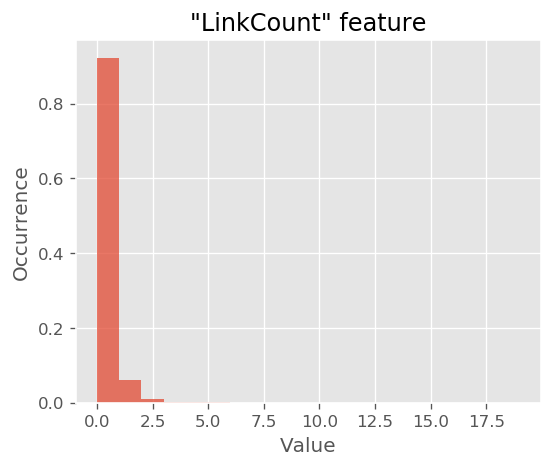

In [95]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

X = np.asarray([[meta[aid]['LinkCount']] for aid in all_answers])

plt.figure(figsize=(5,4), dpi=120) # width and height of the plot in inches

plt.title('"LinkCount" feature')
plt.xlabel('Value')
plt.ylabel('Occurrence')

n, bins, patches = plt.hist(X, normed=1, bins=range(max(X.ravel())-min(X.ravel())), alpha=0.75)

plt.grid(True)
save_png('01_feat_hist_LinkCount')

- Most posts don't contain a link at all, but let's try nevertheless...

## 3.2 Training on 'LinkCount'

- About k nearest neighbor (kNN)
- kNN classifier determines a new data by finding the nearest (euclidean distance) k data point. Then the class of the new data is the majority of the classes of those nearest posts
![alt](https://miro.medium.com/max/1400/1*2zYNhLc522h0zftD1zDh2g.png)

- For more details about kNN, please refer to Chapter2. 
- Here we use sklearn for kNN model and k-fold cross-validation.

In [96]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

N_FOLDS = 10
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=0)

scores = []
for train, test in tqdm(cv.split(X, Y)):
    clf = KNeighborsClassifier()
    clf.fit(X[train], Y[train])
    scores.append(clf.score(X[test], Y[test]))

print("Mean(scores)=%.5f\tStddev(scores)=%.5f"%(np.mean(scores), np.std(scores))) 


Mean(scores)=0.49465	Stddev(scores)=0.01321


- Now that is far from being usable, with only 50% accuracy.
- only one feature 'LinkCount' is not a good indicator for our classification. 

## 3.3 Using more features ('LinkCount', 'NumCodeLines', 'NumTextTokens')

Now we add another two features:
- 'NumCodeLines': number of code lines.
- 'NumTextTokens': number of normal words.

We first check thier distribution:

/home/wang/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


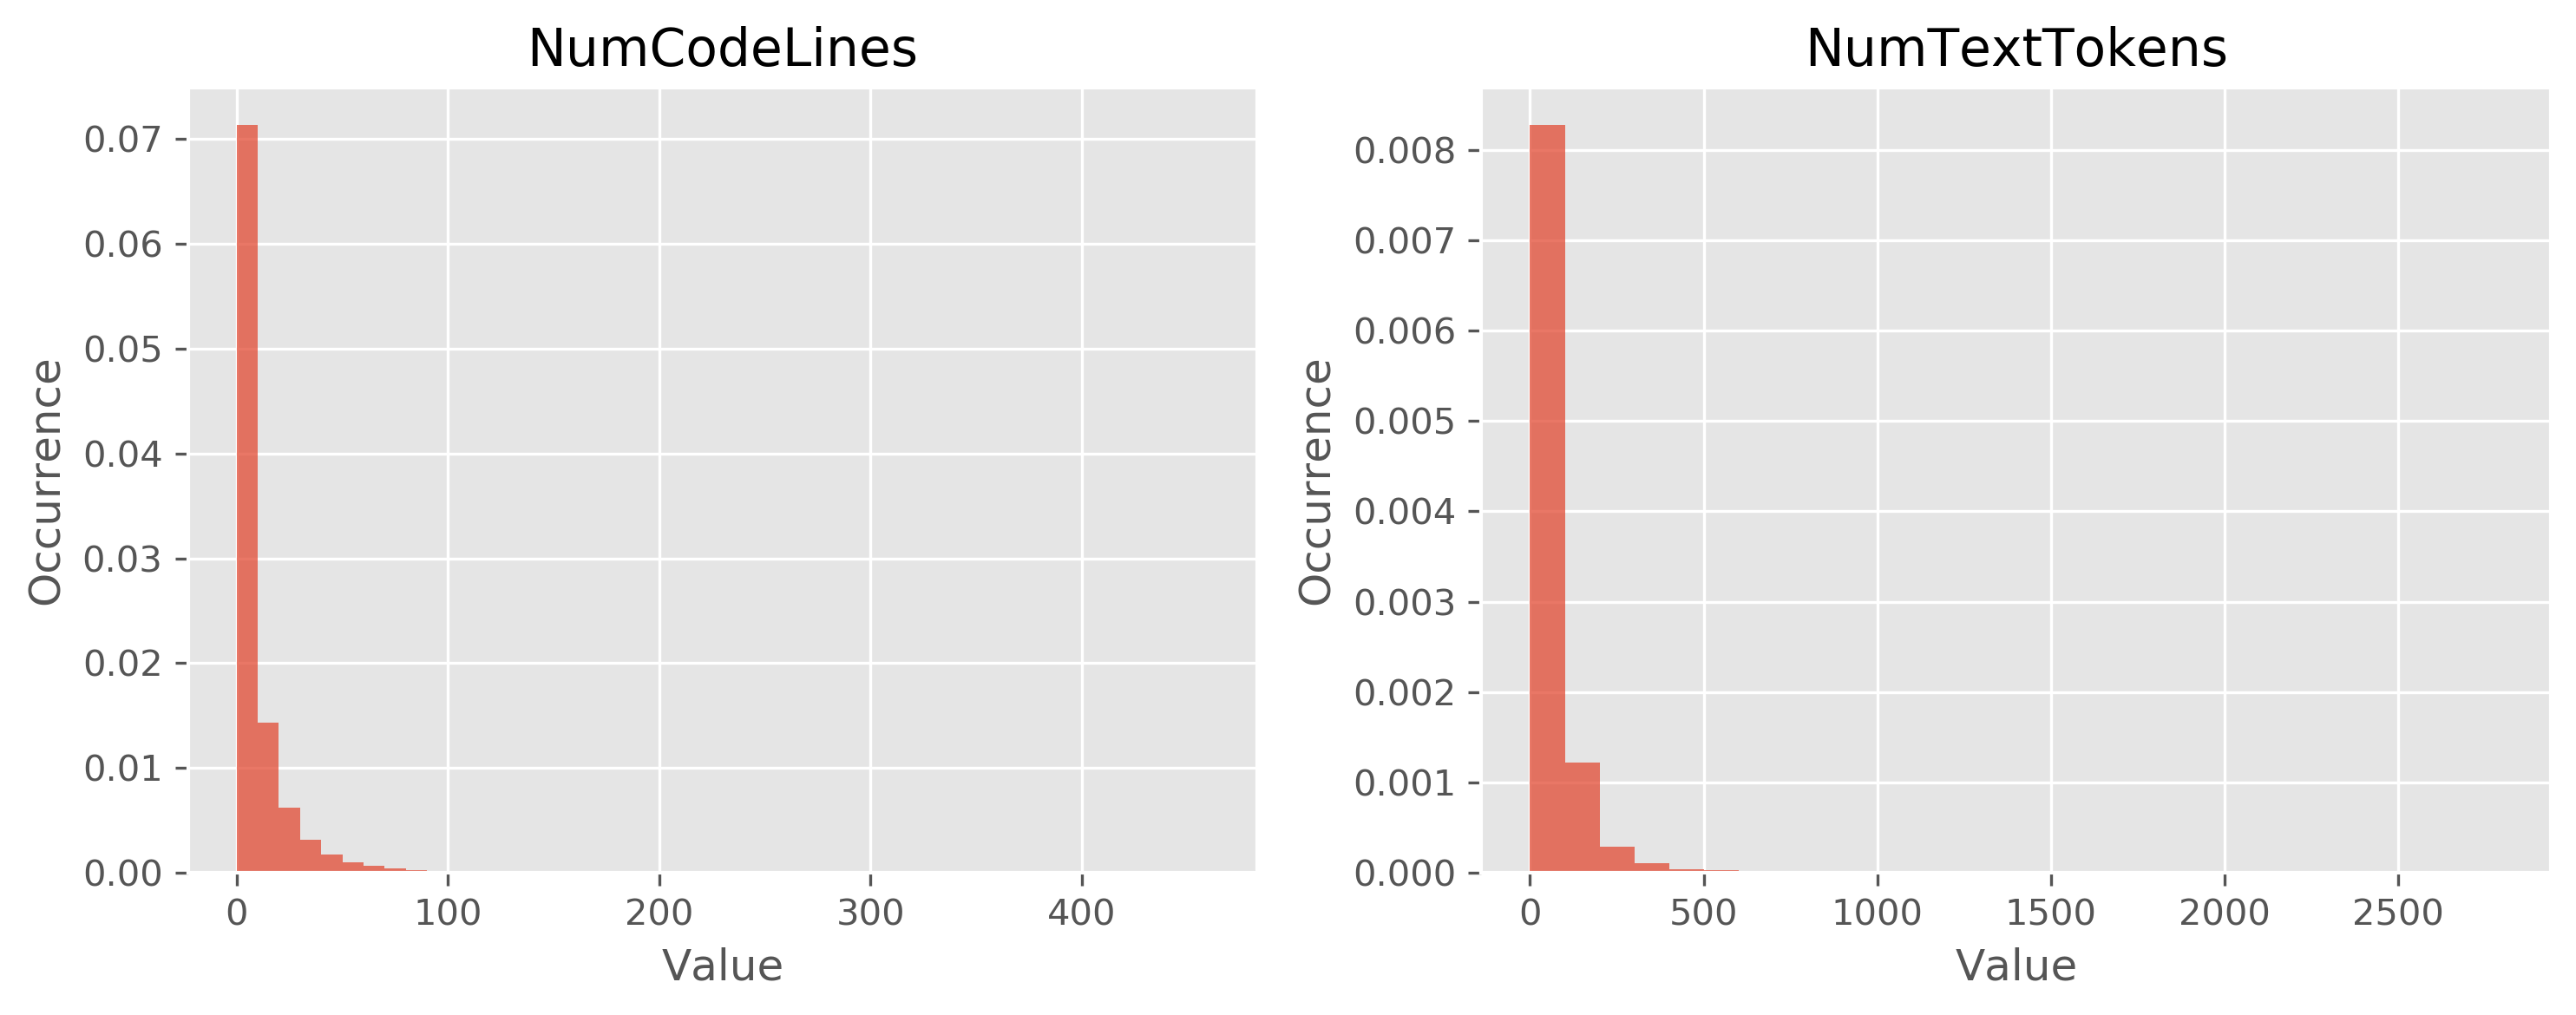

In [97]:
#define a plot function
def plot_feat_hist(data_name_list, filename=None):
    if len(data_name_list) > 1:
        assert filename is not None

    num_rows = int(1 + (len(data_name_list) - 1) / 2)
    num_cols = int(1 if len(data_name_list) == 1 else 2)
    plt.figure(figsize=(5 * num_cols, 4 * num_rows), dpi=300)

    for i in range(num_rows):
        for j in range(num_cols):
            plt.subplot(num_rows, num_cols, 1 + i * num_cols + j)
            x, name = data_name_list[i * num_cols + j]
            plt.title(name)
            plt.xlabel('Value')
            plt.ylabel('Occurrence')
            
            max_val = max(x.ravel())
            if max_val>1000:
                bins = range(0, max_val, 100)
            elif max_val>100:
                bins = range(0, max_val, 10)
            else:
                bins = range(0, max_val)
            
            n, bins, patches = plt.hist(x, bins=bins, normed=1, alpha=0.75)

            plt.grid(True)
            plt.tight_layout()
    
    if not filename:
        filename = "feat_hist_%s" % name.replace(" ", "_")

    save_png(filename)


plot_feat_hist([(np.asarray([[meta[aid]['NumCodeLines']] for aid in all_answers]), 'NumCodeLines'),
                (np.asarray([[meta[aid]['NumTextTokens']] for aid in all_answers]), 'NumTextTokens')],
              '02_feat_hist_CodeLines_TextTokens');

- Since the features vary in their value ranges, we need to standardize them using `StandardScaler()` so that kNN does not bias towards features having larger value intervals. 

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def get_features(aid, feature_names):
    return tuple(meta[aid][fn] for fn in feature_names)

X = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens']) for aid in all_answers], float)

scores = []
for train, test in tqdm(cv.split(X, Y), total=N_FOLDS):
    clf = make_pipeline(StandardScaler(), KNeighborsClassifier())
    clf.fit(X[train], Y[train])
    scores.append(clf.score(X[test], Y[test]))

print("Mean(scores)=%.5f\tStddev(scores)=%.5f"%(np.mean(scores), np.std(scores))) 


Mean(scores)=0.60005	Stddev(scores)=0.01153


- Training on more features improve accuracy quite a bit.
- But still, not good enough.

## 3.4 Designing more features ('LinkCount', 'NumCodeLines', 'NumTextTokens', 'AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams')

So, we extend the feature by even more features:
- AvgSentLen: the average number of words in a sentence, of a posts.
- AvgWordLen: the average number of characters in the words of a posts.
- NumAllCaps: the number of words that are written in uppercase
- NumExclams: the number of exclamation marks.

#### We simply fetch the post texts (sample.tsv), calculate the statistics and add them to the `meta` dictionary.

/home/wang/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


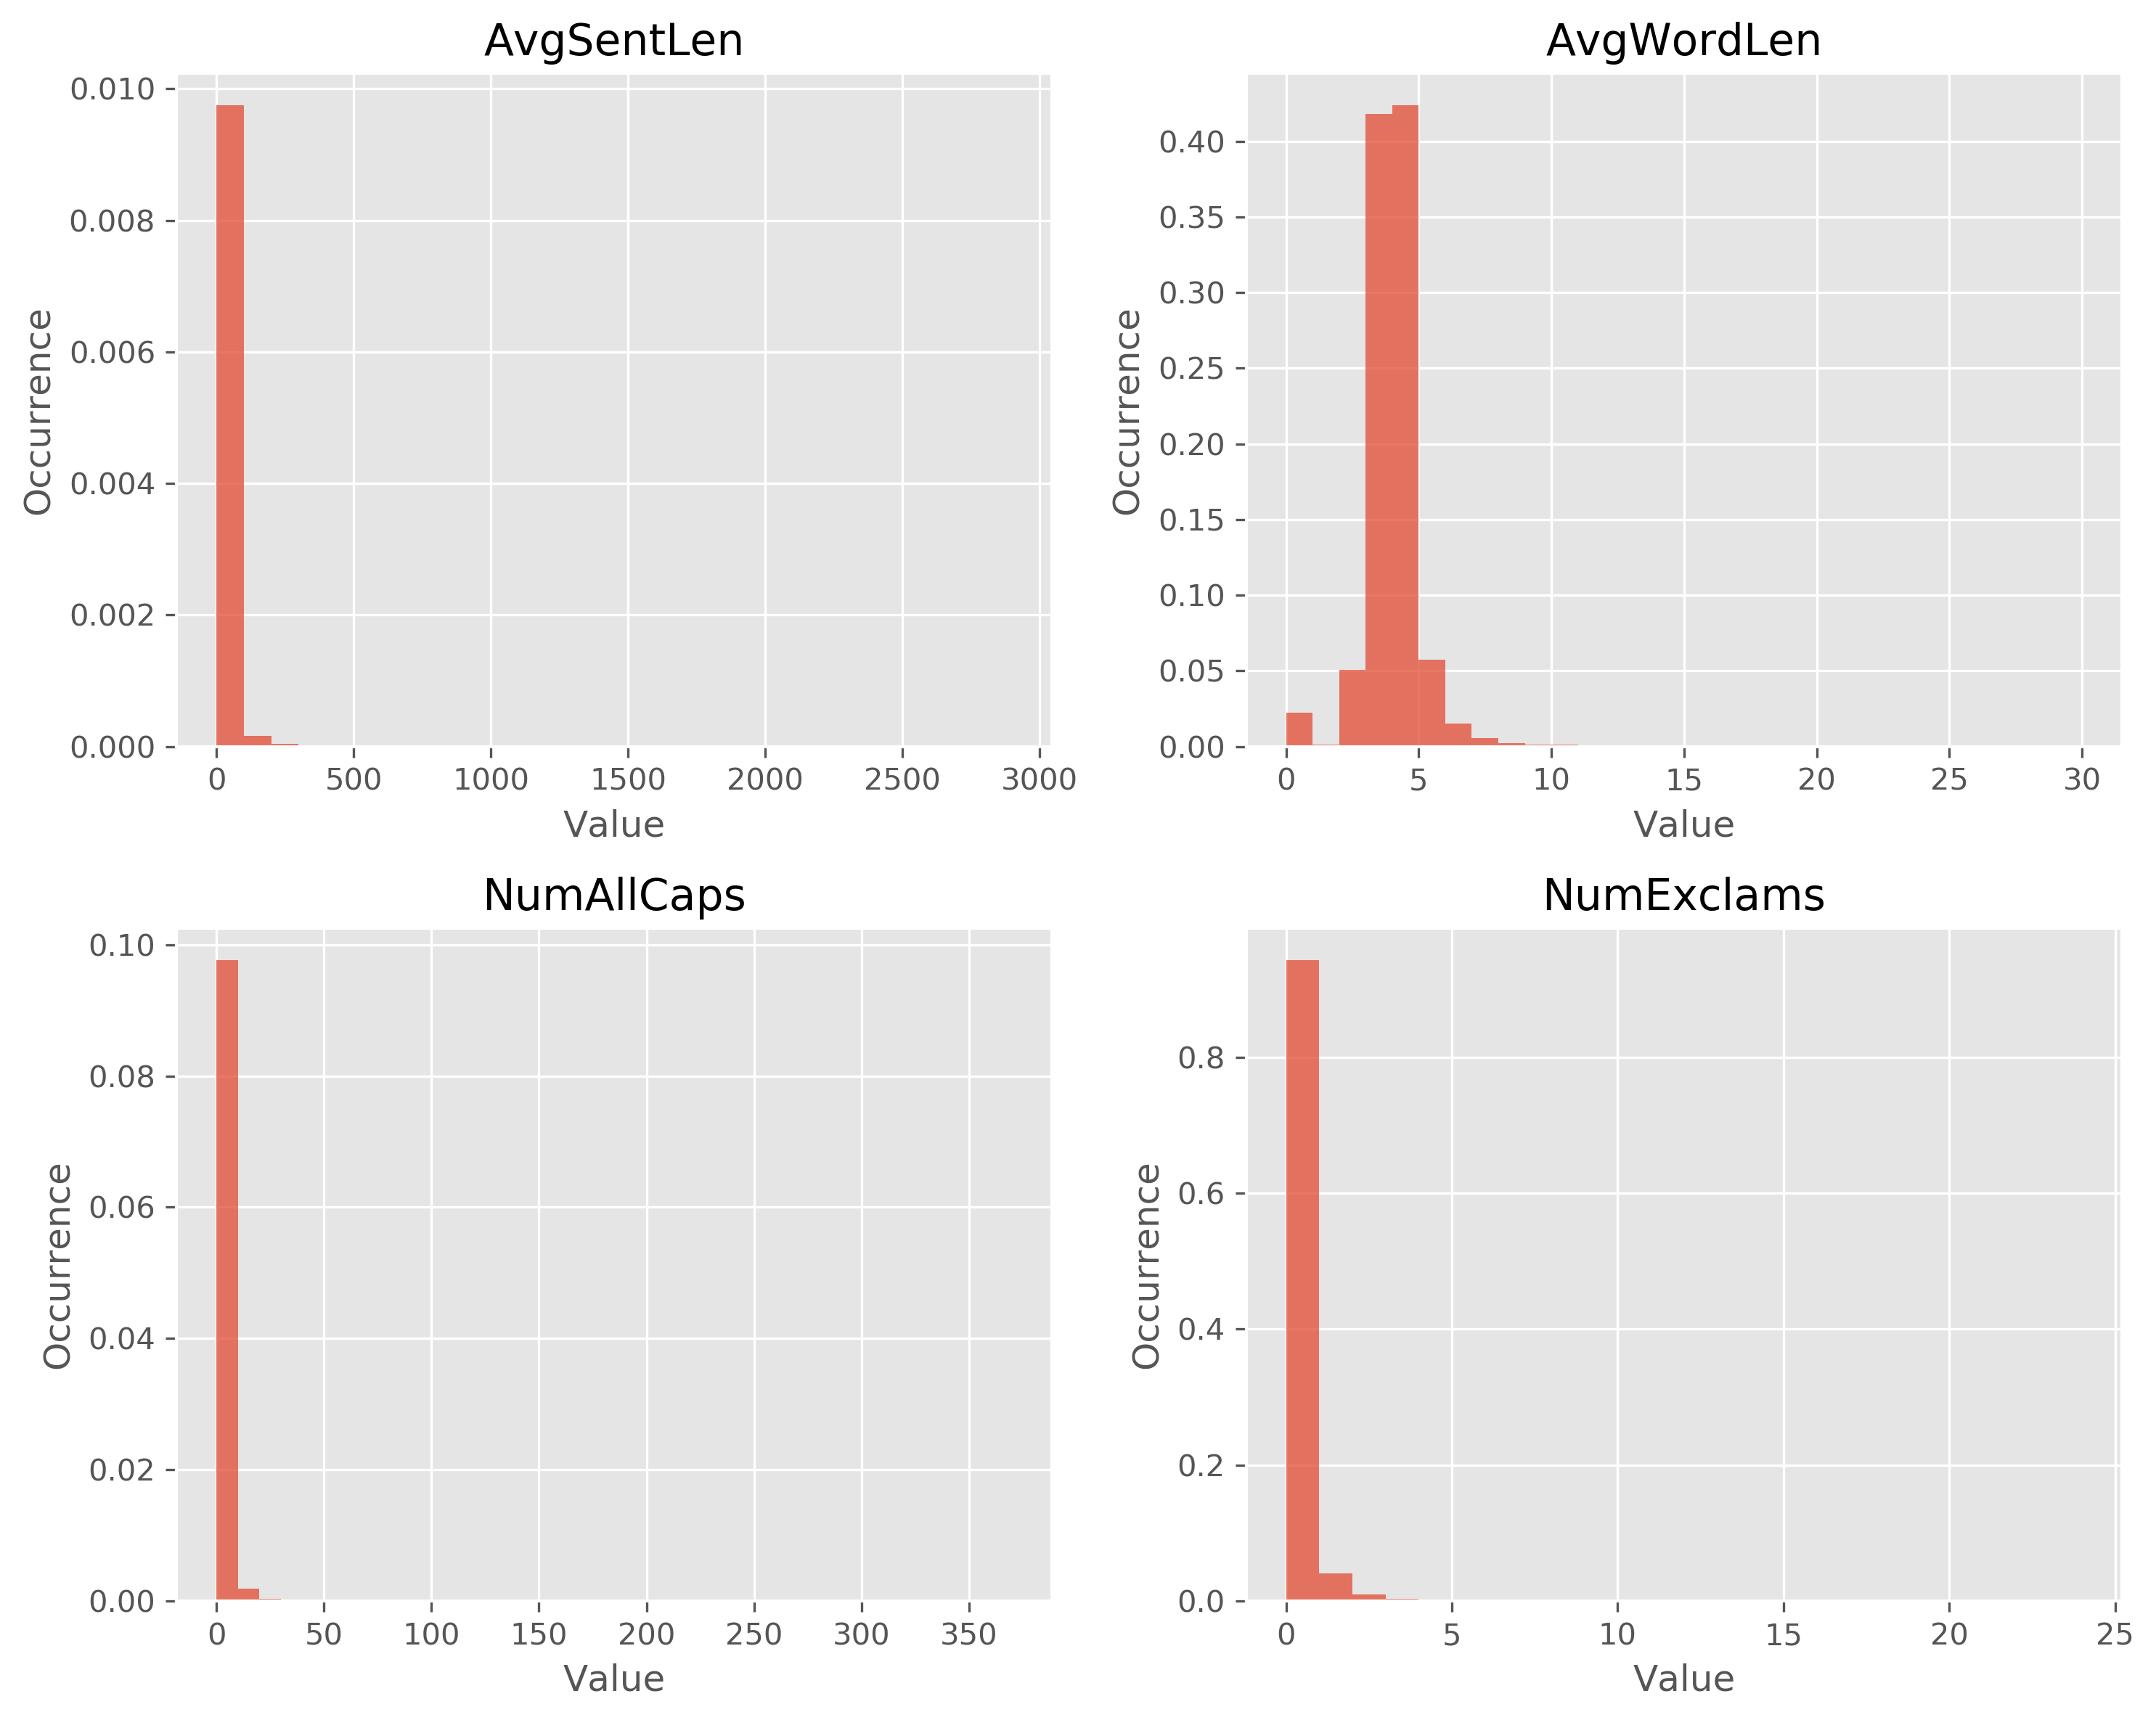

In [99]:
import nltk

def fetch_posts(fn):
    for line in open(fn, 'r', encoding='utf-8'):
        post_id, text = line.split('\t')
        yield int(post_id), text.strip()

def add_sentence_features(m):
    for pid, text in fetch_posts(fn_sample):
        if not text:
            for feat in ['AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']:
                m[pid][feat] = 0
        else:
            sent_lens = [len(nltk.word_tokenize(sent)) for sent in nltk.sent_tokenize(text)]
            m[pid]['AvgSentLen'] = np.mean(sent_lens)
            text_tokens = nltk.word_tokenize(text)
            m[pid]['AvgWordLen'] = np.mean([len(w) for w in text_tokens])
            m[pid]['NumAllCaps'] = np.sum([word.isupper() for word in text_tokens])
            m[pid]['NumExclams'] = text.count('!')

add_sentence_features(meta)

plot_feat_hist([(np.asarray([[meta[aid][feat]] for aid in all_answers], dtype=int), feat) for feat in ['AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']],
              '03_feat_hist_AvgSentLen_AvgWordLen_NumAllCaps_NumExclams');

In [100]:
#show the new meta data
pd.DataFrame(meta).T

,ParentId,Score,NumTextTokens,NumCodeLines,LinkCount,idx,Answers,AvgSentLen,AvgWordLen,NumAllCaps,NumExclams
41412592,-1,2,79,13,0,0,"[41412614, 41412655]",20.5,3.84146,6,0
41412614,4.14126e+07,2,60,0,0,1,NaN,16.25,4.49231,0,0
41412643,-1,2,188,0,0,2,"[41412709, 45287985]",20.4545,3.95111,17,0
41412655,4.14126e+07,-1,55,0,0,3,NaN,16,4.04688,0,0
41412709,4.14126e+07,1,112,6,0,4,NaN,24,4.375,1,0
...,...,...,...,...,...,...,...,...,...,...,...
48020404,4.23472e+07,-1,7,54,0,29995,NaN,6,5.33333,0,0
48021046,4.15349e+07,5,28,21,0,29996,NaN,36,4.75,0,0
48026222,4.36586e+07,2,45,0,0,29997,NaN,60,4.11667,1,0
48028074,4.2446e+07,-3,14,1,0,29998,NaN,13,3.69231,0,0


- Now we use 7 features for kNN 

In [101]:
X = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens', 
                                   'AvgSentLen', 'AvgWordLen', 'NumAllCaps', 
                                   'NumExclams']) for aid in all_answers], float)

scores = []
for train, test in tqdm(cv.split(X, Y), total=N_FOLDS):    
    clf = make_pipeline(StandardScaler(), KNeighborsClassifier())
    clf.fit(X[train], Y[train])
    scores.append(clf.score(X[test], Y[test]))

print("Mean(scores)=%.5f\tStddev(scores)=%.5f"%(np.mean(scores), np.std(scores))) 


Mean(scores)=0.60210	Stddev(scores)=0.00969


- More features didn't give us higher scores.

How to improve the performance?
1. Add more data.
2. Increase or decrease the model complexity.
3. Modify feature numbers
4. Change the model

# STEP4 Bias-variance tradeoff
!!! **本の page 96-97，5.5.1 バイアスーバリアンスのトレードオフ**

My understanding:
- Bias: the difference between predicted value and actual value. High Bias -> underfitting
- Variance: If you use 10 different trainning dataset, you will have 10 model and 10 predicted value. Variance is σ^2 of 10 predicted value. High Variance -> overfitting
- Total Error = Bias+ Variance + Irreducible Error

In [110]:
%%html
<img src=https://jason-chen-1992.weebly.com/uploads/1/0/8/5/108557741/bias-variance-tradeoff_1_orig.png?cb=1460125744 width="500">

<img src=https://cdn-images-1.medium.com/max/1000/1*ePMqfevdkn4GBgvsZKrCcw.png?cb=1460125744 width="500">
    
<img src=https://miro.medium.com/max/936/1*xwtSpR_zg7j7zusa4IDHNQ.png?cb=1460125744 width="500">

- How do we know whether we have high bias or high variance

![alt](http://net.cdn.tupan.net/upload/4/f7/4f7a975a6eb04e50d17f1fd1e1c0793c_thumb.png)
![alt](http://net.cdn.tupan.net/upload/3/fb/3fbc2ca244f3710d9d62170d02614e4d_thumb.png)

## 4.1 Define some function for plot

In [118]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, classification_report

def plot_bias_variance(data_sizes, train_errors, test_errors, name, title):
    plt.figure(num=None, figsize=(6, 5), dpi=150)
    plt.ylim([0.0, 1.0])
    plt.xlabel('Data set size')
    plt.ylabel('Error')
    plt.title("Bias-Variance for '%s'" % name)
    plt.plot(
        data_sizes, test_errors, "--", data_sizes, train_errors, "b-", lw=1)
    plt.legend(["test error", "train error"], loc="upper right")
    plt.grid(True)

def plot_pr(auc_score, name, precision, recall, label=None):
    plt.figure(num=None, figsize=(6, 5), dpi=150)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('P/R (AUC=%0.2f) / %s' % (auc_score, label))
    plt.fill_between(recall, precision, alpha=0.5)
    plt.grid(True)
    plt.plot(recall, precision, lw=1)
    filename = name.replace(" ", "_")+'_pr'
    save_png(filename)

def plot_feat_importance(feature_names, clf, name):
    plt.figure(num=None, figsize=(6, 5), dpi=150)
    coef_ = clf.coef_
    important = np.argsort(np.absolute(coef_.ravel()))
    f_imp = feature_names[important]
    coef = coef_.ravel()[important]
    inds = np.argsort(coef)
    f_imp = f_imp[inds]
    coef = coef[inds]
    xpos = np.array(list(range(len(coef))))
    plt.bar(xpos, coef, width=1, alpha=0.75)

    plt.title('Feature importance for %s' % (name.split('_')[-1]))
    ax = plt.gca()
    ax.set_xticks(np.arange(len(coef)))
    labels = ax.set_xticklabels(f_imp)
    for label in labels:
        label.set_rotation(90)
    filename = name.replace(" ", "_")+'_feat_imp'
    save_png(filename)

def measure(clf_class, parameters, name, X, Y, data_size=None, plot=None, feature_names=None):
    if data_size is not None:
        X = X[:data_size]
        Y = Y[:data_size]

    train_errors = []
    test_errors = []

    scores = []
    roc_scores = []
    fprs, tprs = [], []

    pr_scores = []
    precisions, recalls, thresholds = [], [], []

    for fold_idx, (train, test) in enumerate(cv.split(X, Y)):
        X_train, y_train = X[train], Y[train]
        X_test, y_test = X[test], Y[test]

        only_one_class_in_train = len(set(y_train)) == 1
        only_one_class_in_test = len(set(y_test)) == 1
        if only_one_class_in_train or only_one_class_in_test:
            # this would pose problems later on
            continue

        clf = clf_class(**parameters)

        clf.fit(X_train, y_train)

        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)

        train_errors.append(1 - train_score)
        test_errors.append(1 - test_score)

        scores.append(test_score)
        proba = clf.predict_proba(X_test)

        label_idx = 1
        fpr, tpr, roc_thresholds = roc_curve(y_test, proba[:, label_idx])
        precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:, label_idx])

        roc_scores.append(auc(fpr, tpr))
        fprs.append(fpr)
        tprs.append(tpr)

        pr_scores.append(auc(recall, precision))
        precisions.append(precision)
        recalls.append(recall)
        thresholds.append(pr_thresholds)

        # This threshold is determined at the end of the chapter,
        # where we find conditions such that precision is in the area of
        # about 80%. With it we trade off recall for precision.
        threshold_for_detecting_good_answers = 0.59

        if False:
            print("Clone #%i" % fold_idx)
            print(classification_report(y_test, proba[:, label_idx] >
                  threshold_for_detecting_good_answers, target_names=['not accepted', 'accepted']))

    # get medium clone
    scores_to_sort = pr_scores  # roc_scores
    medium = np.argsort(scores_to_sort)[len(scores_to_sort) // 2]
    # print("Medium clone is #%i" % medium)

    if plot:
        #plot_roc(roc_scores[medium], name, fprs[medium], tprs[medium])
        plot_pr(pr_scores[medium], name, precisions[medium],
                recalls[medium], plot + " answers")

        if hasattr(clf, 'coef_'):
            plot_feat_importance(feature_names, clf, name)
        elif hasattr(clf, 'named_steps'):
            for step, s_clf in clf.named_steps.items():
                if hasattr(s_clf, 'coef_'):
                    plot_feat_importance(feature_names, s_clf, name)

    summary = {'name': name,
               'scores': scores,
               'roc_scores': roc_scores,
               'pr_scores': pr_scores,
               'med_precisions': precisions[medium], 
               'med_recalls': recalls[medium], 
               'med_thresholds': thresholds[medium]}
    
    return np.mean(train_errors), np.mean(test_errors), summary

def bias_variance_analysis(clf_class, parameters, name, X, Y):
    data_sizes = np.arange(40, 2000, 20)

    train_errors = []
    test_errors = []

    for data_size in data_sizes:
        train_error, test_error, _ = measure(clf_class, parameters, name, X, Y, data_size=data_size)
        train_errors.append(train_error)
        test_errors.append(test_error)

    plot_bias_variance(data_sizes, train_errors,
                       test_errors, name, "Bias-Variance for '%s'" % name)

## 4.2 Plot Bias-Variance for kNN (7 features)

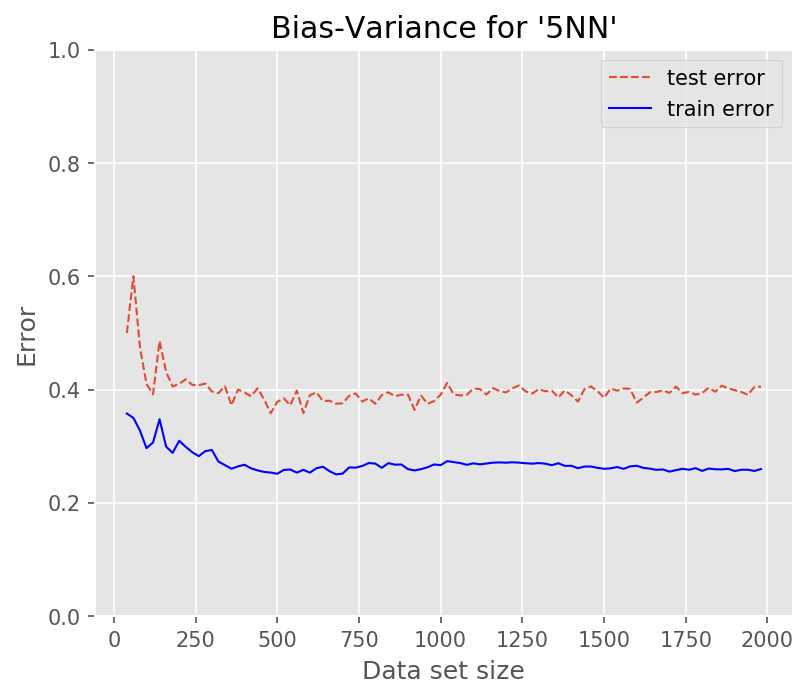

In [119]:
def create_pipeline(**param):
    return make_pipeline(StandardScaler(), KNeighborsClassifier(**param))

bias_variance_analysis(create_pipeline, {'n_neighbors': 5}, "5NN", X, Y)
save_png('04_bv_5NN_all')

- Ploting the errors for different dataset sizes for kNN shows a big gap between train and test errors, hinting at **high variance** problem.

## 4.3  Try less features (only LinkCount and NumTextTokens)

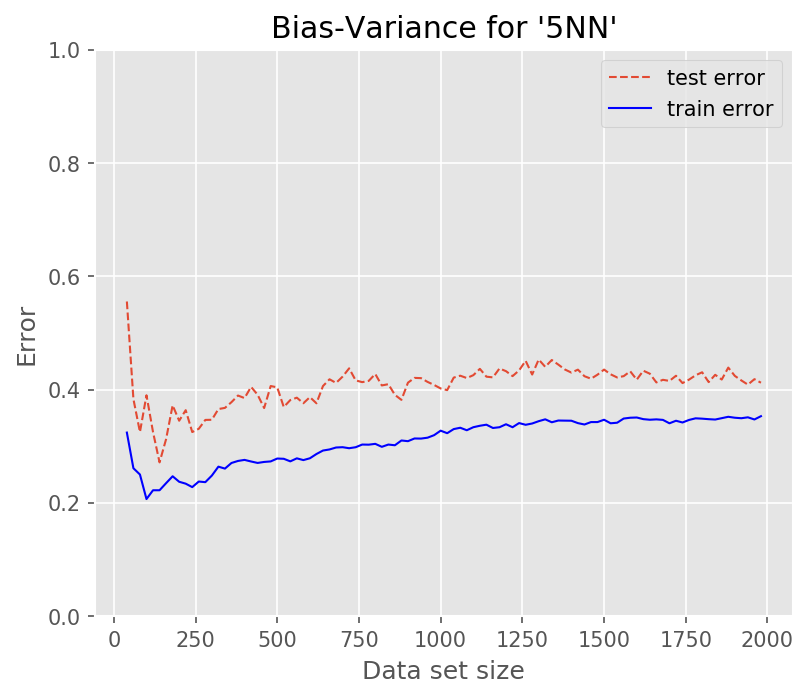

In [120]:
from sklearn.utils import shuffle
X_simp = np.asarray([get_features(aid, ['LinkCount', 'NumTextTokens']) for aid in all_answers], float)
X_simp, Y_simp = shuffle(X_simp, Y, random_state=0)

bias_variance_analysis(create_pipeline, {'n_neighbors': 5}, "5NN", X_simp, Y_simp)
save_png('05_bv_5NN_simp')

- We get similar graphs for less features.
- Does it help to reduce the model complexity by increasing $k$?

## 4.4 Increase k

In [121]:
print('k\tmean(scores)\tstddev(scores)')
for k in [5, 10, 40]:
    _, _, summary = measure(create_pipeline, {'n_neighbors': k}, "%iNN" % k, X, Y)
    print('%d\t%.4f\t\t%.4f' % (k, np.mean(summary['scores']), np.std(summary['scores'])))

k	mean(scores)	stddev(scores)
5	0.6021		0.0097
10	0.6181		0.0117
40	0.6412		0.0100


- It helps a bit, but do we really want to compare with 40 different samples each time? It cost much time.

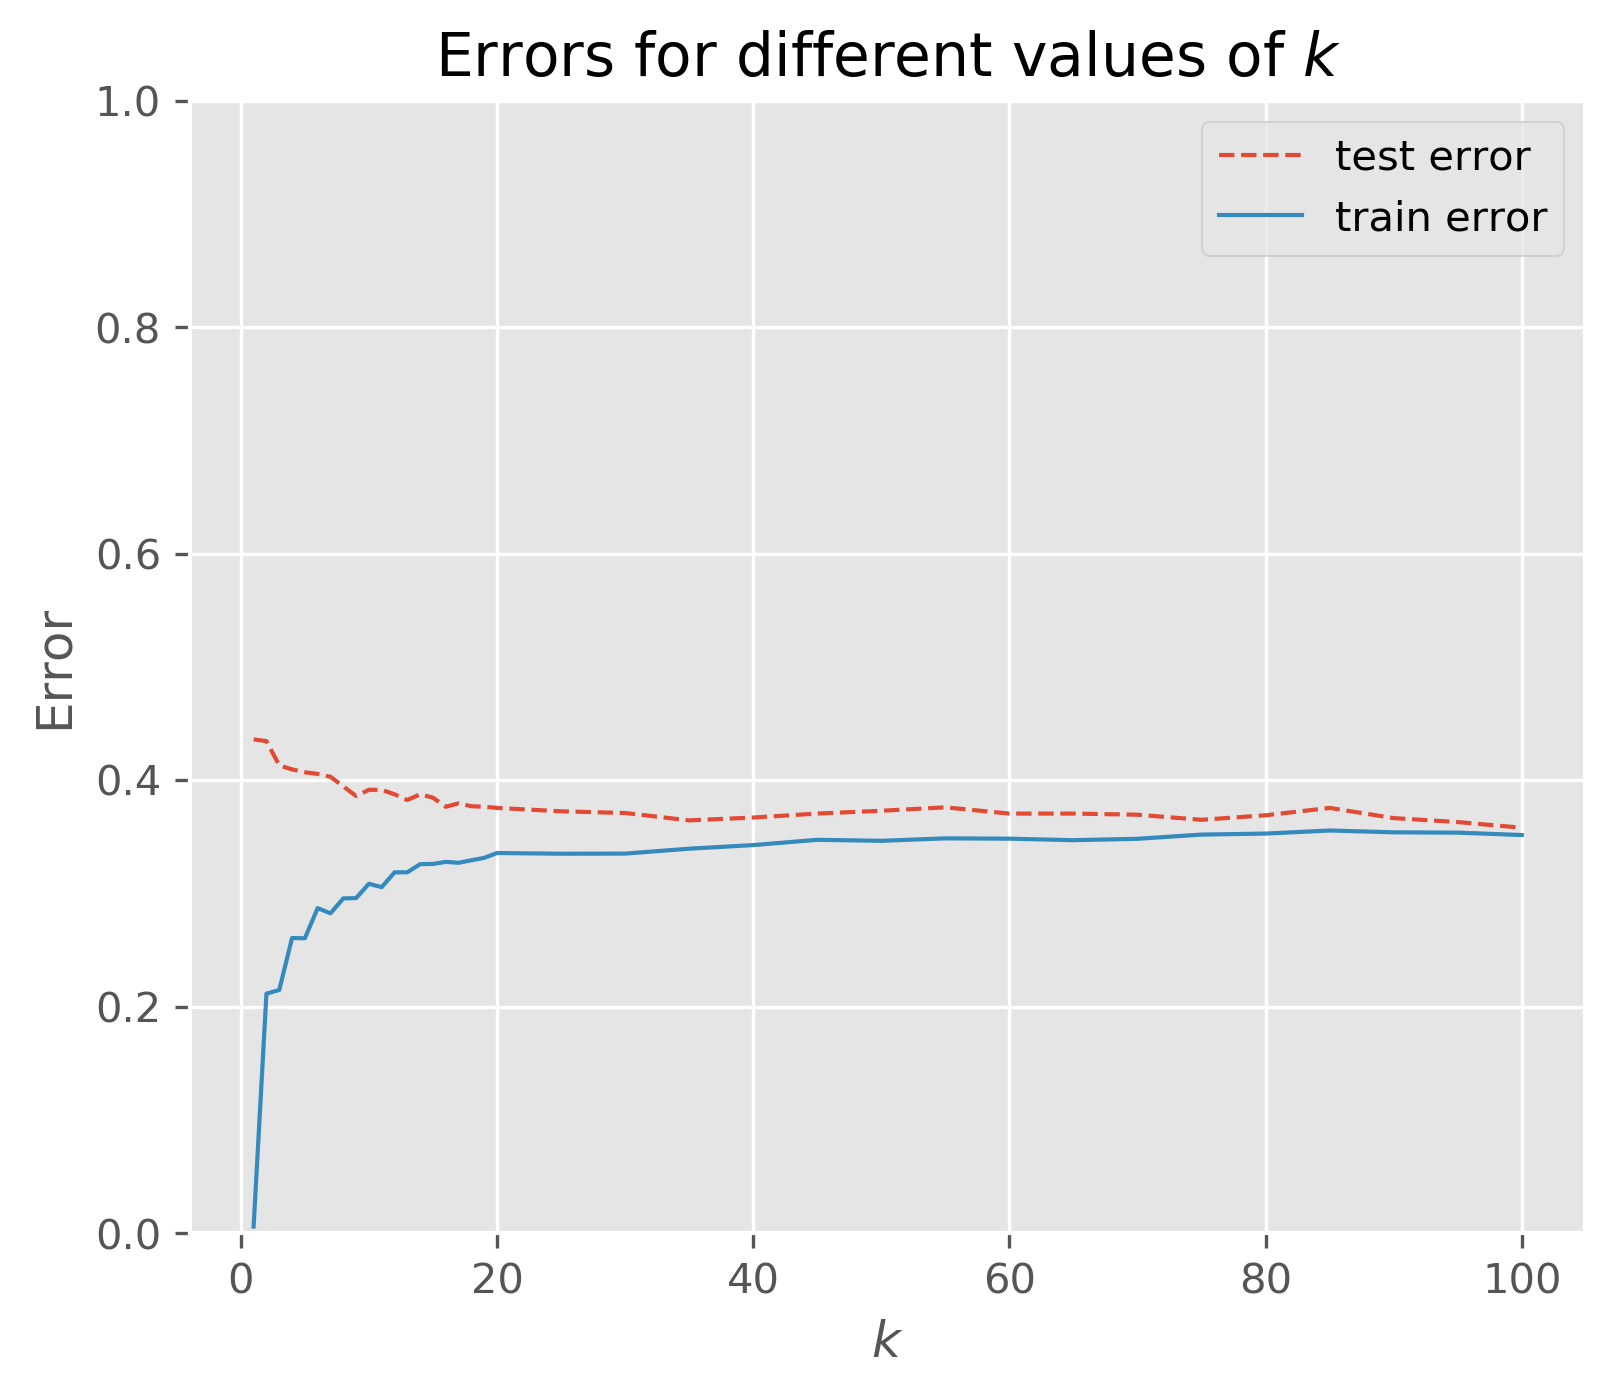

In [122]:
def plot_k_complexity(ks, train_errors, test_errors):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    plt.ylim([0.0, 1.0])
    plt.xlabel('$k$')
    plt.ylabel('Error')
    plt.title('Errors for different values of $k$')
    plt.plot(ks, test_errors, "--", ks, train_errors, "-", lw=1)
    plt.legend(["test error", "train error"], loc="upper right")
    plt.grid(True)
    save_png('06_kcomplexity')

def k_complexity_analysis(clf_class, X, Y):
    # Measure for different k's: [1,2,..,20,25,..,100]
    ks = np.hstack((np.arange(1, 21), np.arange(25, 101, 5)))
    
    train_errors = []
    test_errors = []

    for k in ks:
        train_error, test_error, _ = measure(clf_class, {'n_neighbors': k}, "%dNN" % k, X, Y, data_size=2000)
        train_errors.append(train_error)
        test_errors.append(test_error)

    plot_k_complexity(ks, train_errors, test_errors)


k_complexity_analysis(create_pipeline, X, Y)    

- And we won't get much better with increasing values of $k$.
- So we change our model

# STEP5 Using logistic regression
Creating some toy data to visualize how logistic regression works...

## 5.1 Some example
We have artificial feature values X, plotting with the corresponding classes, 0 or 1.

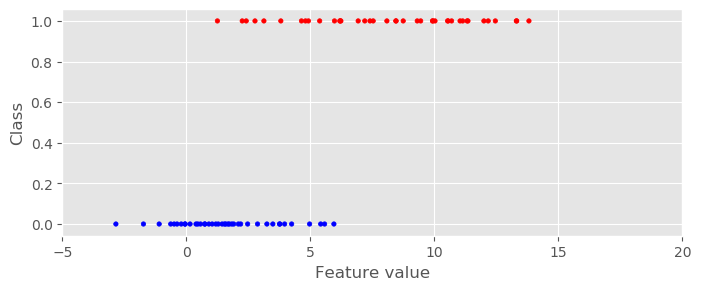

In [131]:
from scipy.stats import norm

np.random.seed(3)

NUM_PER_CLASS = 40
X_log = np.hstack((norm.rvs(2, size=NUM_PER_CLASS, scale=2), norm.rvs(8, size=NUM_PER_CLASS, scale=3)))
y_log = np.hstack((np.zeros(NUM_PER_CLASS), np.ones(NUM_PER_CLASS))).astype(int)

plt.figure(figsize=(8, 3), dpi=100)
plt.grid(True)

plt.xlim((-5, 20))
plt.scatter(X_log, y_log, c=np.array(['blue', 'red'])[y_log], s=10)
plt.xlabel("Feature value")
plt.ylabel("Class")
save_png('06_log_reg_example_data')

- ** Please check "Page 101-103 ロジスティック回帰の簡単の例"**
![alt](https://www.dotnetlovers.com/Images/LogisticRegressionFormula1020201890212AM.png)

In [132]:
from sklearn.linear_model import LogisticRegression

def lr_model(clf, X):
    '''
    https://en.wikipedia.org/wiki/Logistic_regression
    '''
    return 1.0 / (1.0 + np.exp(-(clf.intercept_ + clf.coef_ * X)))

logclf = LogisticRegression()
logclf.fit(X_log.reshape(NUM_PER_CLASS * 2, 1), y_log)
print(np.exp(logclf.intercept_), np.exp(logclf.coef_.ravel()))
print("P(x=-1)=%.2f\tP(x=7)=%.2f" %(lr_model(logclf, -1), lr_model(logclf, 7)))

[0.09437188] [1.80094112]
P(x=-1)=0.05	P(x=7)=0.85


/home/wang/software/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


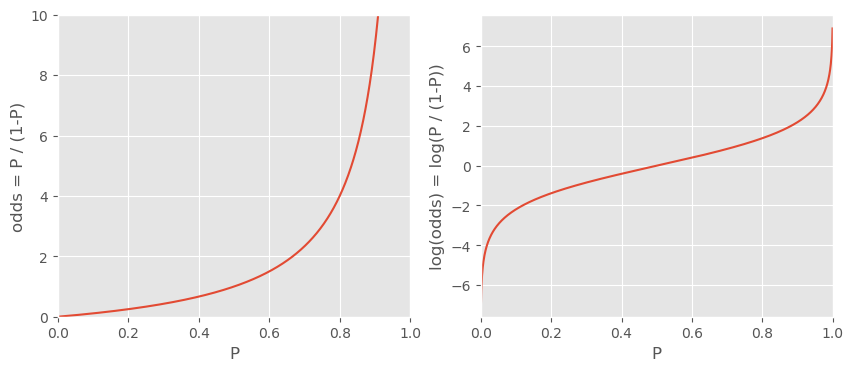

In [135]:
X_odds = np.arange(0.001, 1, 0.001)
plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(1, 2, 1)
plt.xlim((0, 1))
plt.ylim((0, 10))
plt.plot(X_odds, X_odds / (1 - X_odds))
plt.xlabel("P")
plt.ylabel("odds = P / (1-P)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.xlim((0, 1))
plt.plot(X_odds, np.log(X_odds / (1 - X_odds)))
plt.xlabel("P")
plt.ylabel("log(odds) = log(P / (1-P))")
plt.grid(True)
save_png('07_log_reg_log_odds')

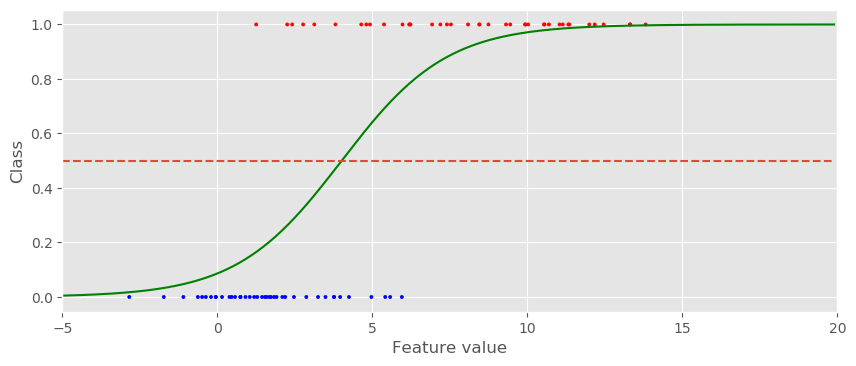

In [136]:
X_range = np.arange(-5, 20, 0.1)

plt.figure(figsize=(10, 4), dpi=100)
plt.xlim((-5, 20))
plt.scatter(X_log, y_log, c=np.array(['blue', 'red'])[y_log], s=5)
plt.plot(X_range, lr_model(logclf, X_range).ravel(), c='green')
plt.plot(X_range, np.ones(X_range.shape[0]) * 0.5, "--")
plt.xlabel("Feature value")
plt.ylabel("Class")
plt.grid(True)
save_png('08_log_reg_example_fitted')

## 5.2 Applying logistic regression to our post classification problem

In [137]:
print('C\tmean(scores)\tstddev(scores)') 
for C in [0.001, 0.01, 0.1, 1.0, 10.0]:
    name = "LogReg C=%.2f" % C
    _, _, summary = measure(LogisticRegression, {'C': C,'solver':'liblinear'}, name, X, Y)

    print('%7.3f\t%.4f\t\t%.4f' % (C, np.mean(summary['scores']), np.std(summary['scores'])))

C	mean(scores)	stddev(scores)
  0.001	0.6375		0.0099
  0.010	0.6411		0.0094
  0.100	0.6388		0.0097
  1.000	0.6383		0.0091
 10.000	0.6383		0.0091


- Here we try different C regularization parameter. With it, we can control the model complexity, similar to k parameter of kNN.
- Smaller C -> more penalization to model complexity -> less complexity

In [138]:
C_best = 0.01

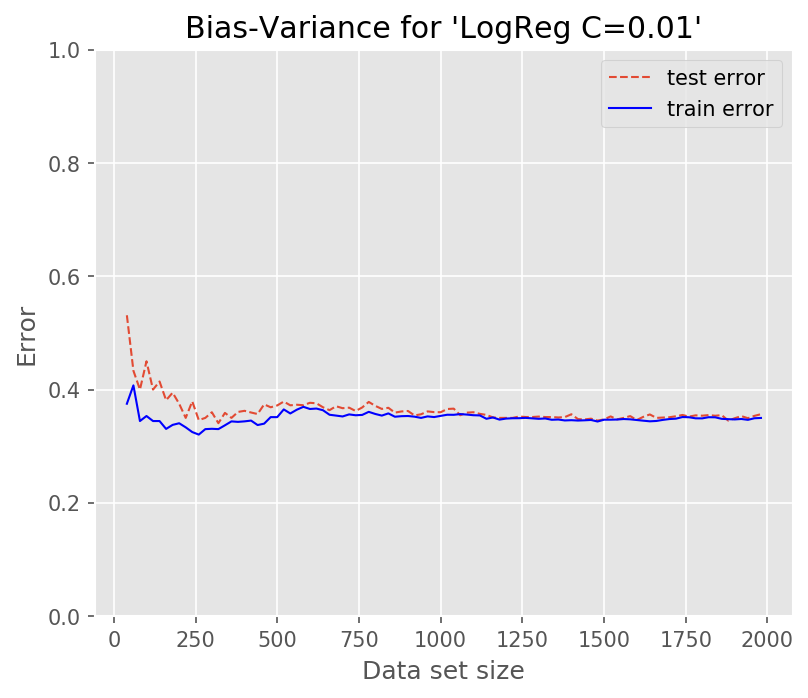

In [139]:
bias_variance_analysis(LogisticRegression, {'C': C_best,'solver':'liblinear'}, "LogReg C=0.01", X, Y)
save_png('09_bv_LogReg')

- Current model has low variance, but still high bias (shown by high train-error)
- Current model might be underfitting.

# STEP6 Looking behind accuracy – precision and recall 
**! Please check "Page 105-107,  5.7 適合率と再現率"**

- High Precision: If our prediction is positive, we have confidence to say such positive is true.
- High recall/Sensitivity: We can detect most of true positive data.

![alt](https://research.aimultiple.com/wp-content/uploads/2019/07/positive-negative-true-false-matrix.png)
![alt](https://pic1.xuehuaimg.com/proxy/csdn/https://img-blog.csdnimg.cn/20190307201742301.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L2JhbnhpYTE5OTU=,size_16,color_FFFFFF,t_70)

![alt](https://modtools.files.wordpress.com/2020/01/roc_pr-1.png?w=946)

- Usually, a classification model including logistic will give us a probability between 0 and 1.
- Then we use thershold 0.5 to decide whether an answer is good or not.
- If we change the thershold from 0 to 1,  we will get a pricision-recall curve and AUC

Good answers...


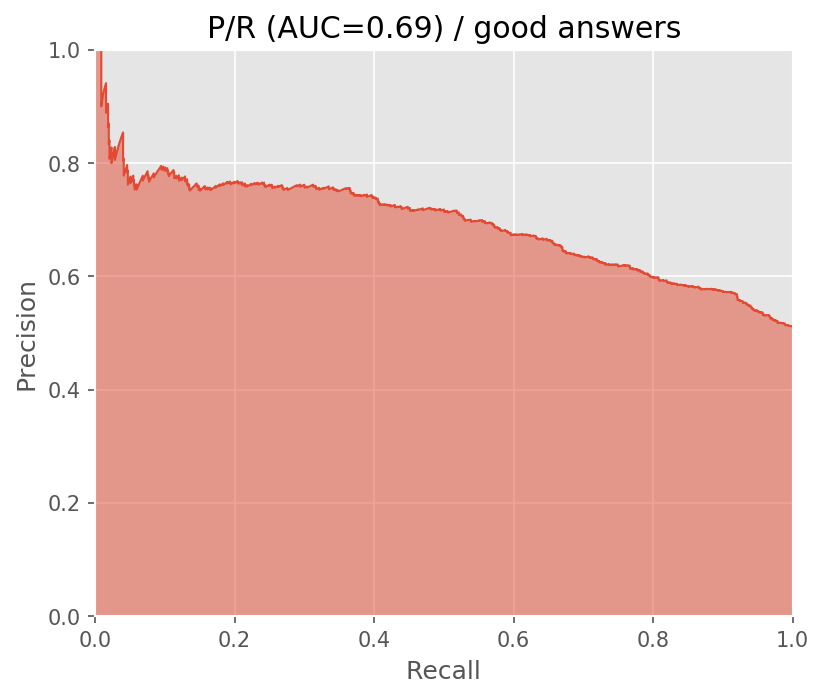

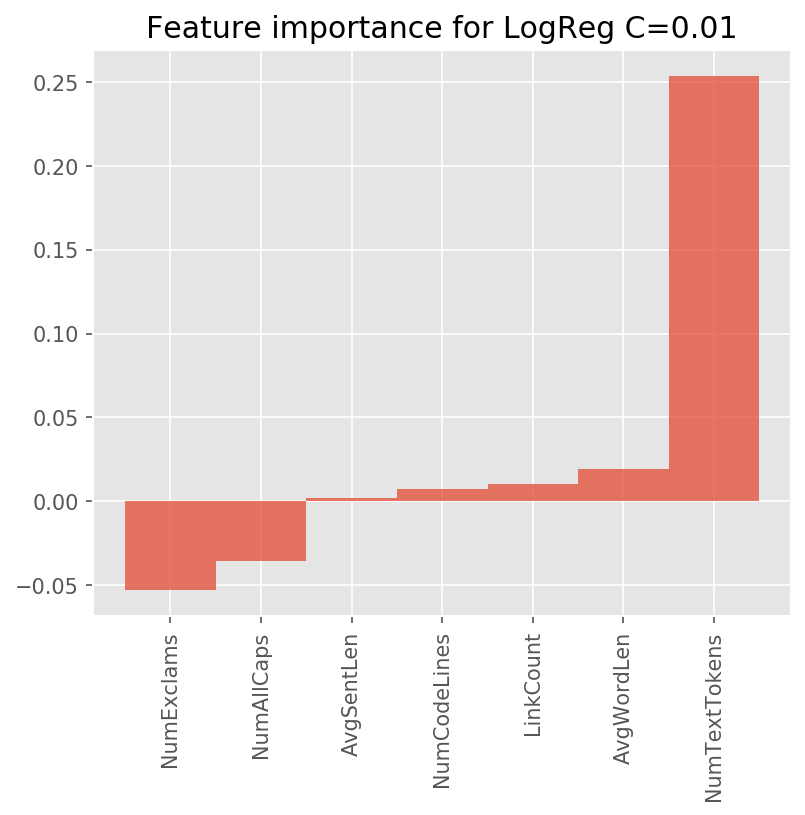

In [142]:
feature_names = np.array((
    'NumTextTokens',
    'NumCodeLines',
    'LinkCount',
    'AvgSentLen',
    'AvgWordLen',
    'NumAllCaps',
    'NumExclams'
))

X_orig = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens', 'AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']) for aid in all_answers])

Y_orig_good = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])
Y_orig_poor = np.asarray([meta[aid]['Score'] <= 0 for aid in all_answers])

X_new, Y_good, Y_poor = shuffle(X_orig, Y_orig_good, Y_orig_poor, random_state=0)
    
name = "LogReg C=%.2f" % C_best

print("Good answers...")
_, _, good_results = measure(LogisticRegression, {'C': C_best,'solver':'liblinear'}, '08_good_'+name, X_new, Y_good, plot='good', feature_names=feature_names)

Poor answers...


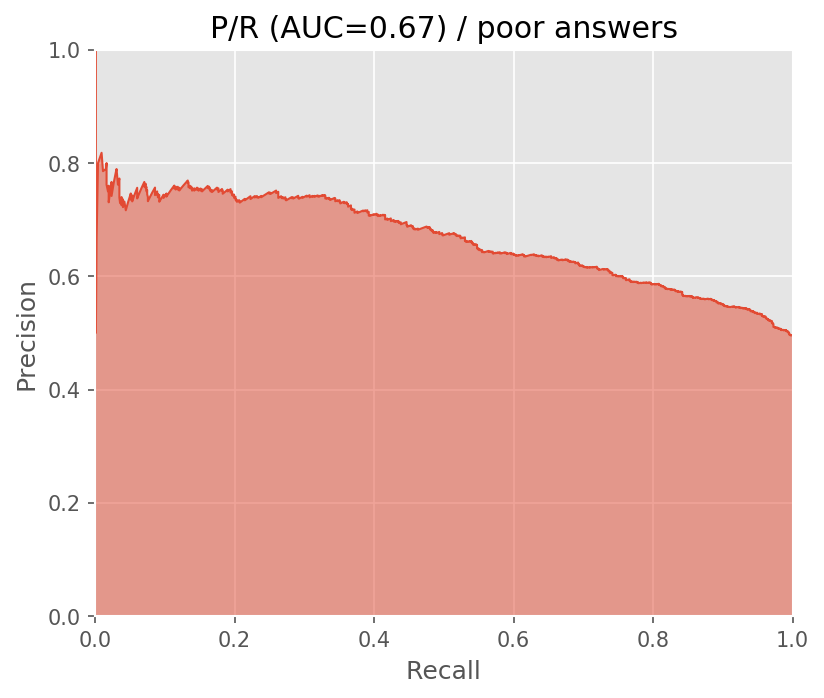

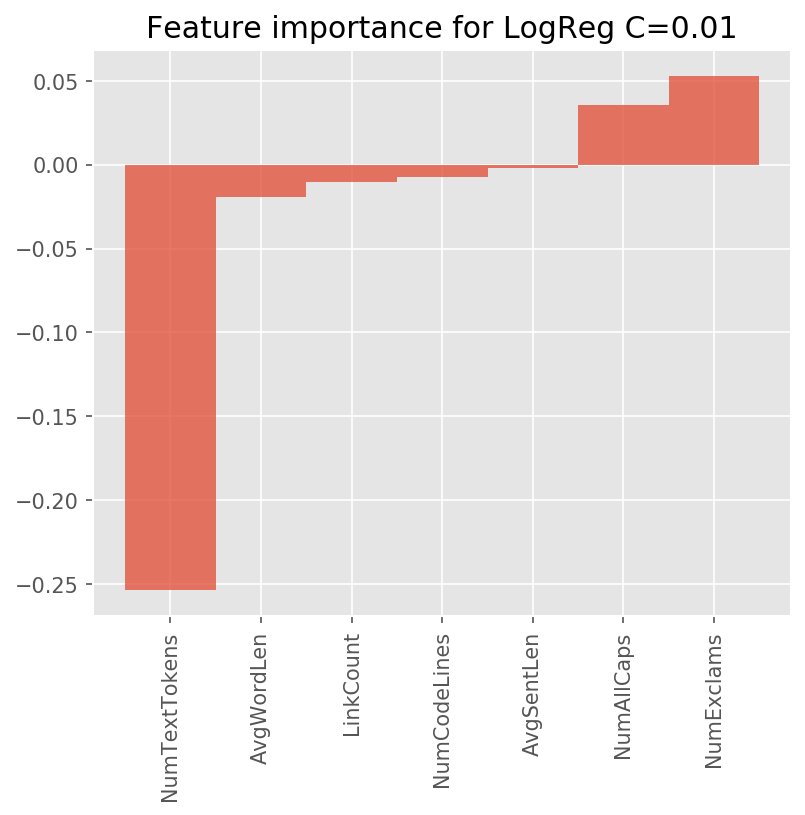

In [143]:
print("Poor answers...")
measure(LogisticRegression, {'C': C_best,'solver':'liblinear'}, '09_poor_'+name, X_new, Y_poor, plot='poor', feature_names=feature_names);

In [144]:
precisions = good_results['med_precisions']
recalls = good_results['med_recalls']
thresholds = np.hstack([[0], good_results['med_thresholds']])

for precision in np.arange(0.77, 0.8, 0.01):
    thresh_idx = precisions >= precision
    print("P=%.2f R=%.2f thresh=%.2f" % (precisions[thresh_idx][0], recalls[thresh_idx][0], thresholds[thresh_idx][0]))

P=0.77 R=0.13 thresh=0.73
P=0.78 R=0.11 thresh=0.77
P=0.79 R=0.10 thresh=0.78
P=0.81 R=0.04 thresh=0.89


In [146]:
good_thresh = 0.77

- The results means we can only detect few (11%) good answers. But we would be resonably sure that they are indeed good (78%).

# STEP7 Save our model and use it to predict new data

In [147]:
clf = LogisticRegression(C=C_best,solver="liblinear")
clf.fit(X, Y)
print(clf.coef_)

[[ 0.2656754   0.00668804  0.01023319  0.00097671  0.02116023 -0.04054235
  -0.05002981]]


In [58]:
import pickle
pickle.dump(clf, open("logreg.dat", "wb"))
clf = pickle.load(open("logreg.dat", "rb"))
print(clf.coef_)   #coefficient for 7 features.

[[ 0.2656754   0.00668804  0.01023319  0.00097671  0.02116023 -0.04054235
  -0.05002981]]


- The classifier is now ready to be used. We create some new data.
- We can now use the classifier's `predict_proba()` to calculate the probabilities for the classes `poor` and `good`:

In [148]:
# Remember that the features are in this order:
# LinkCount, NumCodeLines, NumTextTokens, AvgSentLen, AvgWordLen, NumAllCaps, NumExclams
good_post = (2, 1, 200, 5, 4, 1, 0)
poor_post = (1, 0, 10, 5, 6, 5, 4)
proba = clf.predict_proba([good_post, poor_post])
proba

array([[0.12667663, 0.87332337],
       [0.64702097, 0.35297903]])

In [149]:
proba >= good_thresh

array([[False,  True],
       [False, False]])

- As expected, we manage to detect the first post as good, but cannot say anything about the second
- We can further improve the model.

# STEP8 Classification with Neural Network (tensorflow)

![alt](https://cdn-images-1.medium.com/max/1000/1*s8V2FxT977laKI4DAcQI1w.png)

We can also create a simple neural network with Tensorflow. As we already have the features, we can create a simple one with just one so-called hidden layer.

## 8.1 Preparation data

In [153]:
try:
    import tensorflow as tf
except:
    !pip install tensorflow==1.15
    import tensorflow as tf

In [154]:
X = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens', 'AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']) for aid in all_answers])
Y = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])

- We first covert the output reference. We want to target a probability as close as possible to 0 and 1, but as we use a sigmoid for the output layer that matches -inf to 0 and +inf to 1, we clamp instead to a small value.

In [155]:
Y = Y.astype(np.float32)[:, None]
bce_ceil = 1e-5
Y = Y * (1 - 2 * bce_ceil) + bce_ceil

We know split the data in train/test arrays.

In [156]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8)

In [159]:
print(len(Y_train),", ",len(Y_test))

16000 ,  4000


## 8.2 Settings for tensoflow 

- Let's create helper functions to create the layers. We don't need them now, but they are useful for playing with the network.

In [38]:
def create_dense(x, n_units, name, alpha=0.2):
    # Hidden layer
    h = tf.layers.dense(x, n_units, activation=tf.nn.leaky_relu, name=name)
    return h

def create_output(x):
    # Output layer
    h = tf.layers.dense(x, 1, activation=tf.nn.sigmoid, name="Output")
    return h

![alt](https://i.loli.net/2020/05/22/CunvhYHRjE3B2mq.jpg)

#### Set the hyper parameters
- We use GradientDescentOptimizer algorithm to train our network.
- Here we have 16000 training data, we use batch_size = 1000, so we have 16 batchs for training data.
- After finish each batch, neural network will update its parameter by grad_speed = 0.01. This process called 1 iteration.
- After finish 16 batch (finish all training data once), this process called 1 epochs. We set n_epochs=500, so we run training data 500 times.
- Overall, our model will run training data 500 times, 500x16= 8000 iteration.
- We set 5 nodes for hidden layer, and we have only one hidden layer.
- We use sigmoid for our activation function.

In [39]:
tf.reset_default_graph()

n_epochs = 500
batch_size = 1000
steps = 10
layer1_size = 5

Just as before, we can now create placeholders, and we will use our helper functions to create implicit variables.

In [40]:
X_tf = tf.placeholder(tf.float32, (None, 7), name="Input")
Y_ref_tf = tf.placeholder(tf.float32, (None, 1), name="Target_output")

h1 = create_dense(X_tf, layer1_size, name="Layer1")
Y_tf = create_output(h1)

loss = tf.reduce_mean(tf.square(Y_ref_tf - Y_tf))

grad_speed = .01
my_opt = tf.train.GradientDescentOptimizer(grad_speed)
train_step = my_opt.minimize(loss)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


And now for the training session

## 8.3 Training our neural network

In [41]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss_vec = []
    for epoch in range(n_epochs):
        permut = np.random.permutation(len(X_train))
        for j in range(0, len(X_train), batch_size):
            batch = permut[j:j+batch_size]
            Xs = X_train[batch]
            Ys = Y_train[batch]
            
            sess.run(train_step, feed_dict={X_tf: Xs, Y_ref_tf: Ys})
        
        temp_loss = sess.run(loss, feed_dict={X_tf: X_train, Y_ref_tf: Y_train})
        loss_vec.append(temp_loss)
        if epoch % steps == steps - 1:
            print('Epoch #%i  loss = %s' % (epoch, temp_loss))

    predict_train = sess.run(Y_tf, feed_dict={X_tf: X_train})
    predict_test = sess.run(Y_tf, feed_dict={X_tf: X_test})

Epoch #9  loss = 0.32114875
Epoch #19  loss = 0.27324525
Epoch #29  loss = 0.24595688
Epoch #39  loss = 0.23838125
Epoch #49  loss = 0.23458712
Epoch #59  loss = 0.23248339
Epoch #69  loss = 0.23093008
Epoch #79  loss = 0.23081662
Epoch #89  loss = 0.22885494
Epoch #99  loss = 0.22844224
Epoch #109  loss = 0.22750685
Epoch #119  loss = 0.22716409
Epoch #129  loss = 0.22701378
Epoch #139  loss = 0.22680476
Epoch #149  loss = 0.22590204
Epoch #159  loss = 0.22551005
Epoch #169  loss = 0.22523674
Epoch #179  loss = 0.22506931
Epoch #189  loss = 0.22487012
Epoch #199  loss = 0.22460541
Epoch #209  loss = 0.22463064
Epoch #219  loss = 0.22459973
Epoch #229  loss = 0.22402339
Epoch #239  loss = 0.22405973
Epoch #249  loss = 0.22380304
Epoch #259  loss = 0.22393933
Epoch #269  loss = 0.22375418
Epoch #279  loss = 0.22353253
Epoch #289  loss = 0.22346455
Epoch #299  loss = 0.22358742
Epoch #309  loss = 0.22327179
Epoch #319  loss = 0.22340158
Epoch #329  loss = 0.22322191
Epoch #339  loss = 0.

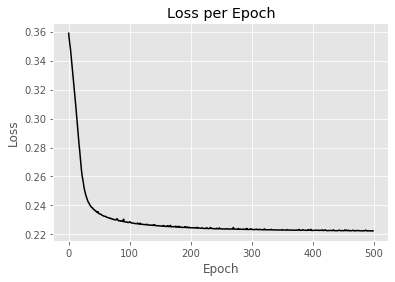

In [42]:
plt.plot(loss_vec, 'k-')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
save_png('tf_classification_loss')

Lower Loss is better. 

## 8.4 Test the performance

In [43]:
from sklearn.metrics import accuracy_score

score = accuracy_score(Y_train > .5, predict_train > .5)
print("Score (on training data): %.2f" % score)
score = accuracy_score(Y_test > .5, predict_test > .5)
print("Score (on testing data): %.2f" % score)

Score (on training data): 0.65
Score (on testing data): 0.64


- The results seems good.

- We can also display the confusion matrix 

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

        Poor       0.63      0.72      0.67      7993
        Good       0.68      0.58      0.62      8007

    accuracy                           0.65     16000
   macro avg       0.65      0.65      0.65     16000
weighted avg       0.65      0.65      0.65     16000

Confusion matrix, without normalization
[[5775 2218]
 [3372 4635]]


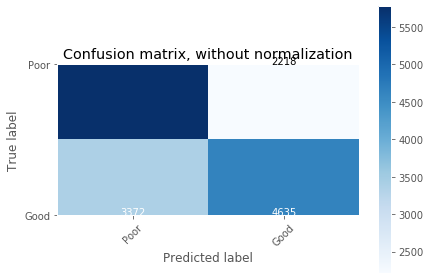

              precision    recall  f1-score   support

        Poor       0.62      0.72      0.67      2007
        Good       0.66      0.56      0.61      1993

    accuracy                           0.64      4000
   macro avg       0.64      0.64      0.64      4000
weighted avg       0.64      0.64      0.64      4000

Confusion matrix, without normalization
[[1439  568]
 [ 880 1113]]


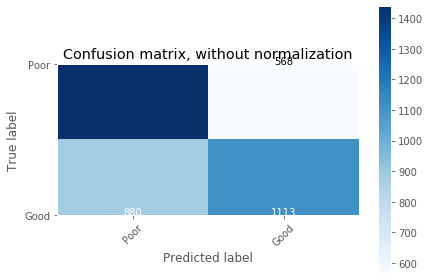

In [45]:
class_names = ["Poor", "Good"]
from sklearn import metrics
print(metrics.classification_report(Y_train > .5, predict_train > .5, target_names=class_names))
plot_confusion_matrix(metrics.confusion_matrix(Y_train > .5, predict_train > .5), classes=class_names,
                      title='Confusion matrix, without normalization')
plt.grid(False)
save_png('tf_classification_train')
plt.show()
print(metrics.classification_report(Y_test > .5, predict_test > .5, target_names=class_names))
plot_confusion_matrix(metrics.confusion_matrix(Y_test > .5, predict_test > .5), classes=class_names,
                      title='Confusion matrix, without normalization')
plt.grid(False)
save_png('tf_classification_test')

- Training data and test data performs similar.
- We can still see many misclassification.

-------------#############

# The END, Thanks for your listening.